# Alphavec Example - Search

This notebook demonstrates running `alphavec.grid_search()` to perform a parameter grid search.

Install the optional dependencies to run this notebook: `pip install -r requirements.dev.txt`

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import HTML, display

from alphavec import MarketData, MetricKey, SimConfig, grid_search, tearsheet, Metrics

## Load example market data

In [2]:
data_dir = Path("./data")

weights = pd.read_feather(data_dir / "weights.feather")
close_prices = pd.read_feather(data_dir / "close_prices.feather")
open_prices = pd.read_feather(data_dir / "open_prices.feather")
funding_rates = pd.read_feather(data_dir / "funding_rates.feather")

display(weights.tail())
display(close_prices.tail())

symbols = weights.columns.tolist()
print("assets", len(symbols))
print("start", weights.index.min())
print("end", weights.index.max())


symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,NaN,-0.031875,NaN,NaN,NaN,NaN,NaN,NaN,-0.097401,0.029260,...,NaN,NaN,NaN,0.0,NaN,-0.008459,NaN,NaN,-0.000699,NaN
2025-12-03 00:00:00+00:00,NaN,-0.027453,NaN,NaN,NaN,NaN,NaN,NaN,-0.083888,0.025201,...,-0.112875,NaN,NaN,0.0,0.000131,0.000000,NaN,NaN,0.000000,NaN
2025-12-04 00:00:00+00:00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.086195,0.025894,...,-0.115978,NaN,NaN,0.0,0.000135,NaN,NaN,NaN,NaN,NaN
2025-12-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053187,0.015978,...,-0.071529,NaN,0.0,0.0,0.000083,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.051574,0.000000,...,-0.069359,NaN,0.0,NaN,0.000081,NaN,NaN,NaN,NaN,NaN


symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,168.79,0.38834,NaN,NaN,0.039585,0.013016,0.006575,0.23618,1.8922,3.9386,...,9.6541,0.028973,0.033617,0.048958,1.3000,0.008721,0.043165,0.11868,0.004023,0.007918
2025-12-03 00:00:00+00:00,197.87,0.44952,NaN,NaN,0.043865,0.013717,0.006534,0.25134,2.0184,4.2969,...,9.4366,0.038904,0.038245,0.050670,1.4093,0.010014,0.049838,0.14077,0.004803,0.008968
2025-12-04 00:00:00+00:00,190.48,0.43922,NaN,NaN,0.043271,0.013139,0.006329,0.23680,1.9350,4.1867,...,9.5340,0.037351,0.037513,0.048951,1.3982,0.009621,0.047621,0.13732,0.004764,0.008697
2025-12-05 00:00:00+00:00,183.37,0.41582,NaN,NaN,0.040539,0.012715,0.006519,0.23167,1.7443,4.0007,...,8.6429,0.038500,0.033500,0.047205,1.3706,0.009068,0.044926,0.13049,0.004387,0.008298
2025-12-06 00:00:00+00:00,187.32,0.41342,NaN,NaN,0.042355,0.013159,0.006486,0.23631,1.7555,4.0015,...,8.5287,0.034134,0.033014,0.047661,1.3989,0.009380,0.046659,0.14057,0.004512,0.008415


assets 151
start 2023-01-01 00:00:00+00:00
end 2025-12-06 00:00:00+00:00


## Define a weight generator

`generate_weights(params)` can close over any data you want (here: `close_prices`).

This example uses a simple momentum signal and normalizes the weights to target a chosen gross leverage.

In [3]:
def generate_weights(params):
    """Simple cross-sectional momentum signal from the sample market data.

    Notes:
    - Uses close-to-close momentum over `lookback`.
    - Uses an EWMA smoother for stability.
    - Shifts weights by 1 period to avoid lookahead.
    """

    lookback = int(params["lookback"])
    smooth_span = int(params["smooth_span"])
    leverage = float(params["leverage"])

    # Close-to-close momentum (more realistic than synthetic data).
    mom = close_prices.pct_change(lookback, fill_method=None)
    mom = mom.replace([np.inf, -np.inf], np.nan)

    if smooth_span > 1:
        mom = mom.ewm(span=smooth_span, adjust=False, min_periods=max(3, smooth_span // 5)).mean()

    # Cross-sectional z-score each day (only across tradable assets).
    tradable = close_prices.notna() & close_prices.shift(-1).notna() & open_prices.notna()
    x = mom.where(tradable)
    mu = x.mean(axis=1)
    sig = x.std(axis=1, ddof=1).replace(0.0, np.nan)
    z = x.sub(mu, axis=0).div(sig, axis=0)

    # Clip extreme z-scores and convert to weights.
    z = z.clip(-3.0, 3.0).fillna(0.0)
    denom = z.abs().sum(axis=1).replace(0.0, np.nan)
    w = z.div(denom, axis=0).fillna(0.0)

    # Avoid lookahead: signal at t is traded at t+1.
    w = w.shift(1).fillna(0.0)
    return w * leverage


base_params = {
    "lookback": 20,
    "smooth_span": 10,
    "leverage": 1.0,
}

weights_preview = generate_weights(base_params)
weights_preview.tail()


symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,0.001629,-0.007663,0.0,0.0,-0.010172,-0.001564,-0.000352,-0.010529,-0.009432,-0.000966,...,-0.004529,-0.013140,-0.005928,-0.001625,0.000765,-0.007136,-0.005493,-0.004705,-0.007046,0.003165
2025-12-03 00:00:00+00:00,0.001962,-0.007461,0.0,0.0,-0.010301,-0.001082,0.000711,-0.011047,-0.010293,-0.000409,...,-0.004483,-0.009877,-0.006511,0.000274,0.001614,-0.006884,-0.005274,-0.004466,-0.007070,0.003387
2025-12-04 00:00:00+00:00,0.003286,-0.007120,0.0,0.0,-0.010835,-0.001347,0.000921,-0.012596,-0.012289,0.000278,...,-0.005613,-0.004908,-0.006881,-0.000308,0.001673,-0.006370,-0.004694,-0.003106,-0.006189,0.004014
2025-12-05 00:00:00+00:00,0.005612,-0.006315,0.0,0.0,-0.010949,-0.001591,0.001091,-0.014027,-0.014051,0.000679,...,-0.007785,-0.000475,-0.008603,-0.000597,0.002158,-0.005828,-0.004378,-0.001519,-0.004126,0.004175
2025-12-06 00:00:00+00:00,0.007103,-0.005571,0.0,0.0,-0.010531,-0.001651,0.002174,-0.014382,-0.015348,0.000897,...,-0.010242,0.005467,-0.010082,0.000332,0.002818,-0.005269,-0.004183,-0.000303,-0.002976,0.004242


## Run a 2D grid search with metric objective

We search over `lookback x leverage` and `lookback x smooth_span`. The objective metric defaults to `Annualized Sharpe` (and must match the simulation metrics table index exactly).

In [4]:
search_sets = [
    {"lookback": [5, 10, 20, 40, 80], "leverage": [0.5, 1.0, 1.5, 2.0]},
    {"lookback": [5, 10, 20, 40, 80], "smooth_span": [1, 5, 10, 20, 40]},
]

grid_results = grid_search(
    generate_weights=generate_weights,
    objective_metric=Metrics.SHARPE,
    maximize=True,
    base_params=base_params,
    param_grids=search_sets,
    progress=True,
    market=MarketData(
        close_prices=close_prices,
        exec_prices=open_prices.shift(-1),  # next-period open prices
        funding_rates=funding_rates,
    ),
    config=SimConfig(
        init_cash=10_000.0,
        fee_rate=0.0002,
        slippage_rate=0.001,
        order_notional_min=10.0,
        start_period="2023-01-01",  # datetime slice
        end_period="2025-12-06",    # datetime slice
        freq_rule="1D",
        trading_days_year=365,
        risk_free_rate=0.003,
    ),
    max_workers=8,
)

grid_results.objective_metric


/var/folders/zn/5x7ccvw94gl5pg2_6rkq7ngw0000gp/T/ipykernel_75491/1505196465.py:6: UserWarning: Grid parameter 'lookback' overrides base_params. Consider removing from base_params to avoid confusion.
  grid_results = grid_search(
/var/folders/zn/5x7ccvw94gl5pg2_6rkq7ngw0000gp/T/ipykernel_75491/1505196465.py:6: UserWarning: Grid parameter 'leverage' overrides base_params. Consider removing from base_params to avoid confusion.
  grid_results = grid_search(
/var/folders/zn/5x7ccvw94gl5pg2_6rkq7ngw0000gp/T/ipykernel_75491/1505196465.py:6: UserWarning: Grid parameter 'smooth_span' overrides base_params. Consider removing from base_params to avoid confusion.
  grid_results = grid_search(


grid_search (Annualized Sharpe):   0%|          | 0/45 [00:00<?, ?run/s]

'Annualized Sharpe'

In [5]:
grid_results.table.head()

,grid_index,grid_name,param1_name,param1_value,param2_name,param2_value,objective_metric,objective_value
3,0,grid_0,lookback,5,leverage,0.5,Annualized Sharpe,0.387159
0,0,grid_0,lookback,5,leverage,1.0,Annualized Sharpe,0.323097
7,0,grid_0,lookback,5,leverage,1.5,Annualized Sharpe,0.247168
2,0,grid_0,lookback,5,leverage,2.0,Annualized Sharpe,0.167955
5,0,grid_0,lookback,10,leverage,0.5,Annualized Sharpe,0.726917


## Extract metrics from the best result

Use `MetricKey` constants for type-safe metric extraction from the best simulation result.

In [6]:
# Access the best simulation result
best = grid_results.best
print(f"Best parameters: {best.params}")
print()

# Extract metrics using the unified API (delegates to best.result)
print("Best Result Metrics:")
print(f"  Annualized Sharpe:    {grid_results.metric_value(MetricKey.ANNUALIZED_SHARPE):.3f}")
print(f"  Annualized Return %:  {grid_results.metric_value(MetricKey.ANNUALIZED_RETURN_PCT):.2f}%")
print(f"  Max Drawdown %:       {grid_results.metric_value(MetricKey.MAX_DRAWDOWN_EQUITY_PCT):.2f}%")
print(f"  Calmar Ratio:         {grid_results.metric_value(MetricKey.CALMAR_RATIO):.3f}")
print()

# Get all performance metrics as a dict
perf = grid_results.metrics_dict("Performance")
print("All Performance Metrics:", perf)

# You can also access via best.result directly if needed
print(f"\nDirect access: {best.result.metric_value(MetricKey.ANNUALIZED_SHARPE):.3f}")

Best parameters: {'lookback': np.int64(10), 'smooth_span': 10, 'leverage': np.float64(0.5)}

Best Result Metrics:
  Annualized Sharpe:    0.727
  Annualized Return %:  0.11%
  Max Drawdown %:       -17.20%
  Calmar Ratio:         0.632

All Performance Metrics: {'Annualized return %': 0.10871530517713057, 'Annualized volatility': 0.1454296058106751, 'Annualized Sharpe': 0.7269173603808988, 'Max drawdown (equity) %': -17.20332018155356, 'Total return %': 35.36707878559151, 'Total return': 3536.707878559151}

Direct access: 0.727


## Generate a tearsheet from the best result

,Category,Value,Note
Metric,,,
Period frequency,Meta,1D,Interpretation: Sampling frequency used for annualization. Smaller periods are generally more granular (but can be noisier).
Benchmark Asset,Meta,None,Interpretation: Column name of the benchmark asset used for alpha/beta and benchmark charts (if provided).
Fee %,Meta,0.0002,Interpretation: Trading fee rate applied to order notional (decimal units; e.g. 0.001 = 10 bps).
Slippage %,Meta,0.001,Interpretation: Slippage applied against the trader on execution prices (decimal units; e.g. 0.001 = 10 bps).
Init Cash,Meta,10000.0,Interpretation: Initial cash (starting equity) used for the simulation.
Trading Days Year,Meta,365,Interpretation: Trading days per year used for annualization.
Risk Free Rate,Meta,0.003,Interpretation: Annual risk-free rate used for Sharpe/Sortino (decimal units).
Simulation start date,Meta,2023-01-01 00:00:00+00:00,Interpretation: First timestamp in the simulation index. Earlier start dates generally make estimates more statistically stable.
Simulation end date,Meta,2025-12-06 00:00:00+00:00,Interpretation: Last timestamp in the simulation index. More recent end dates generally better reflect current market conditions.

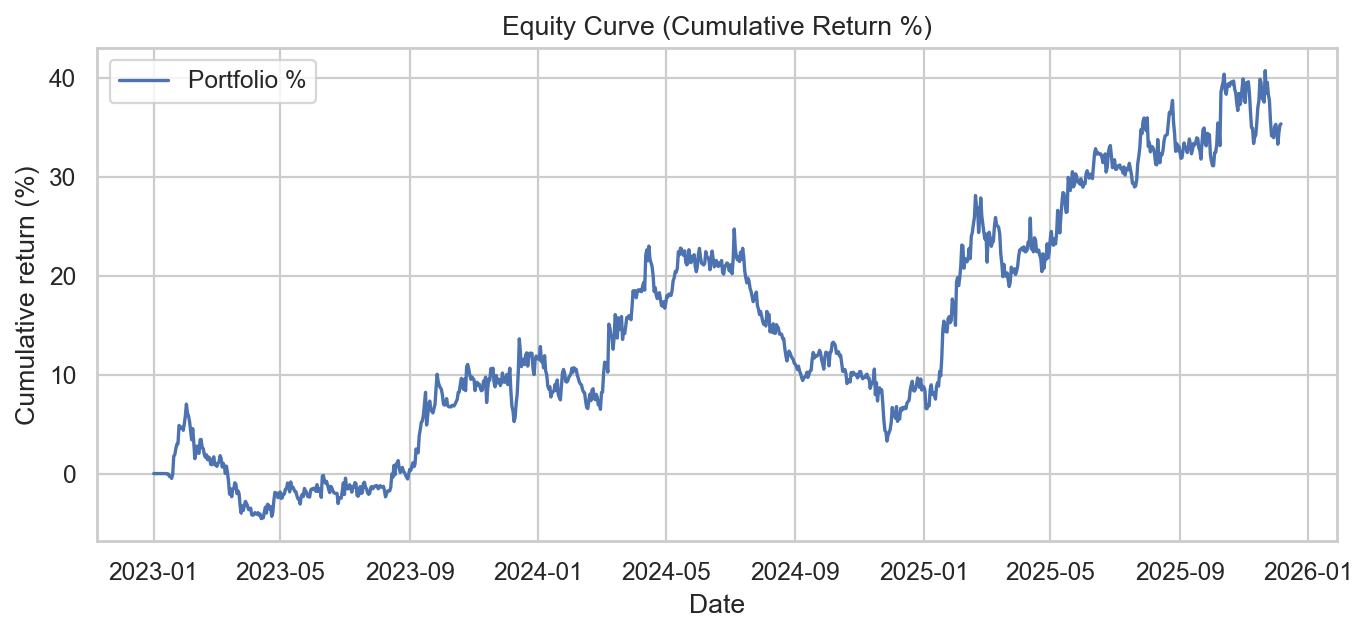
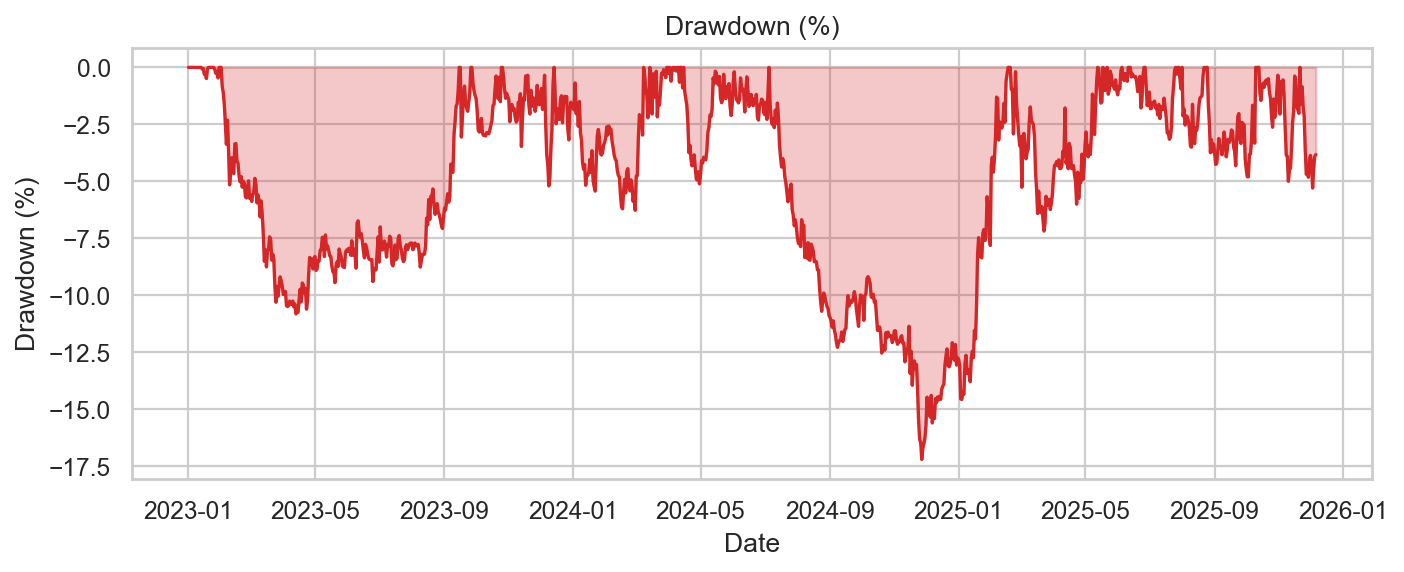
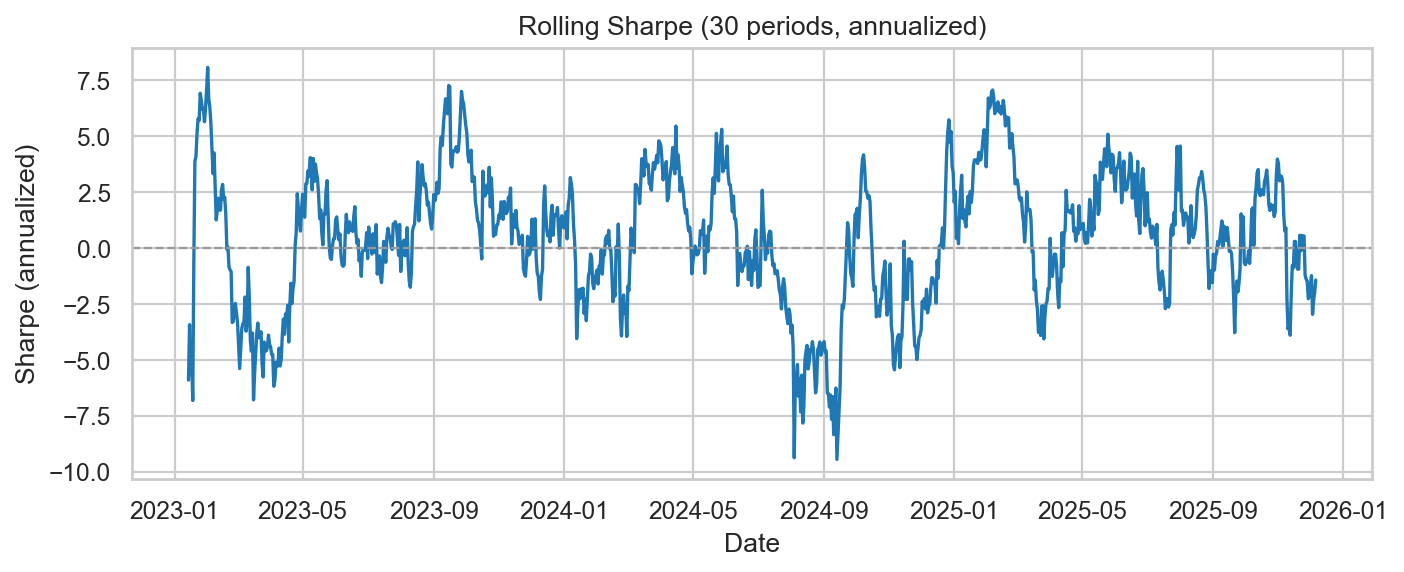
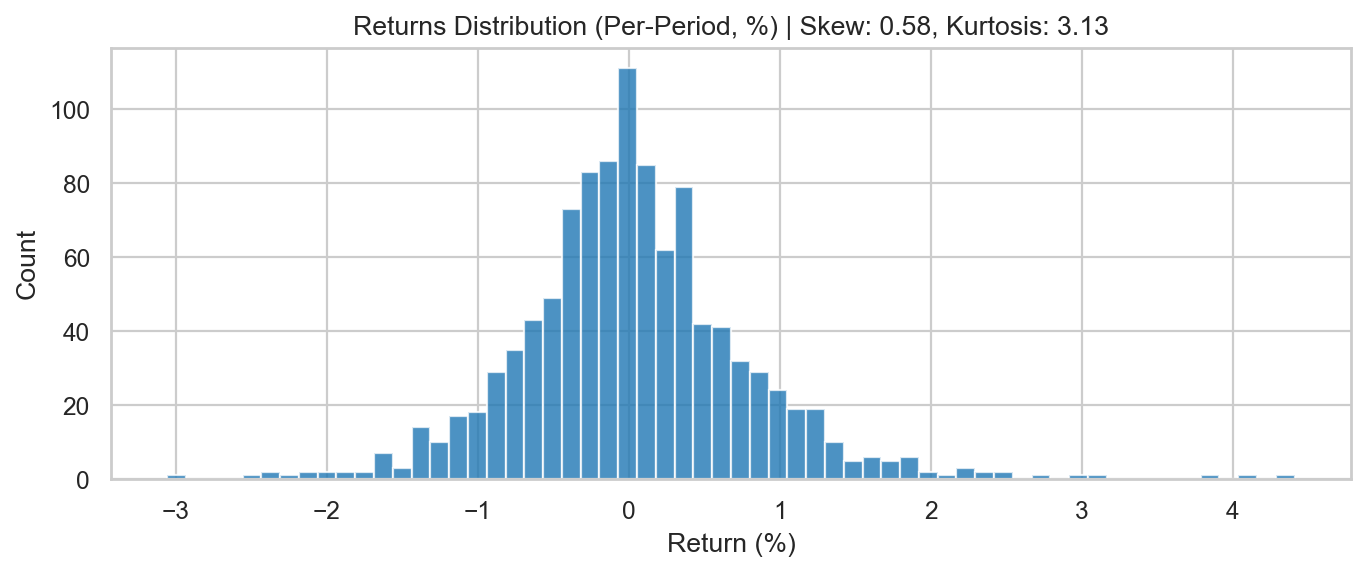
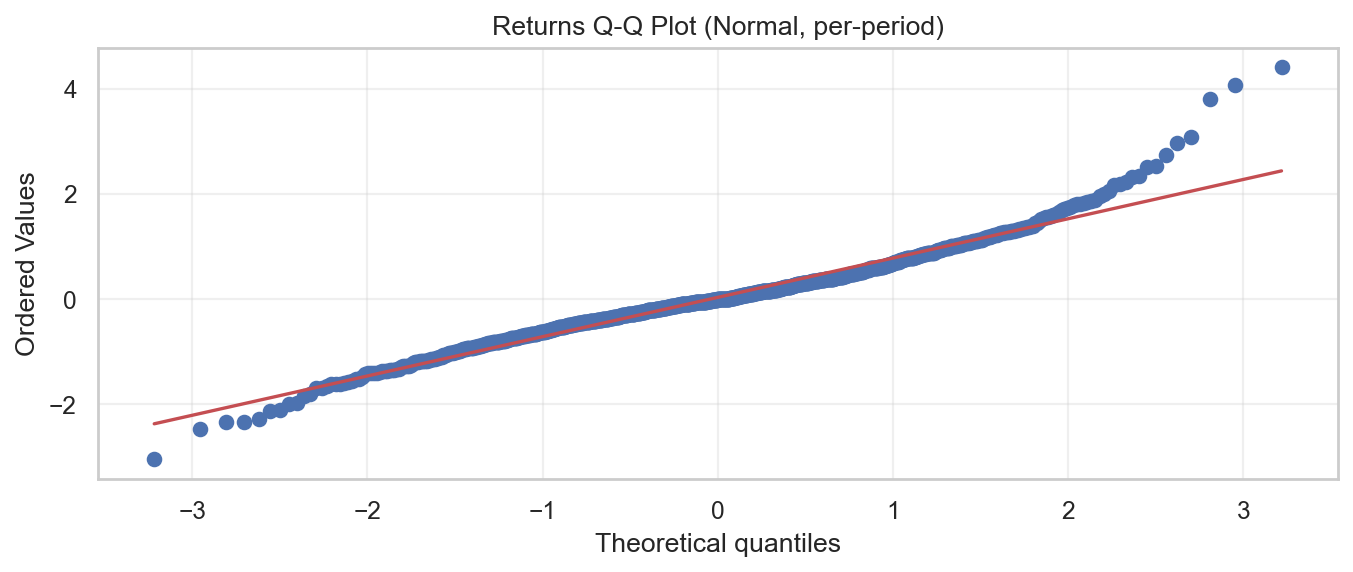
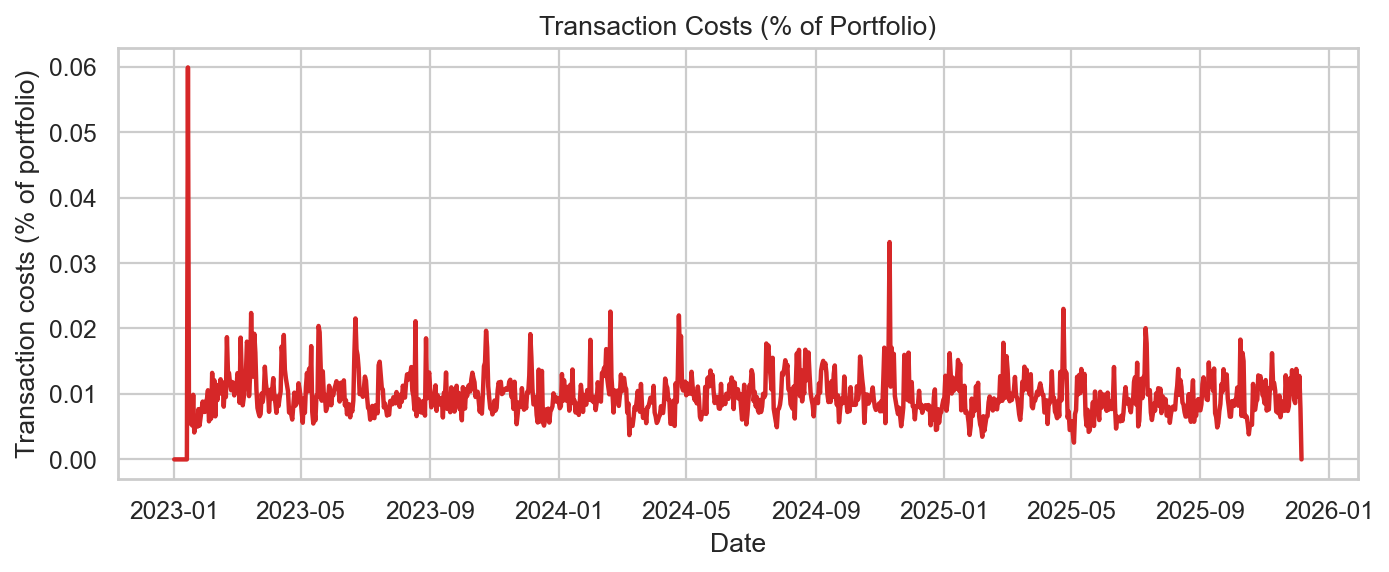
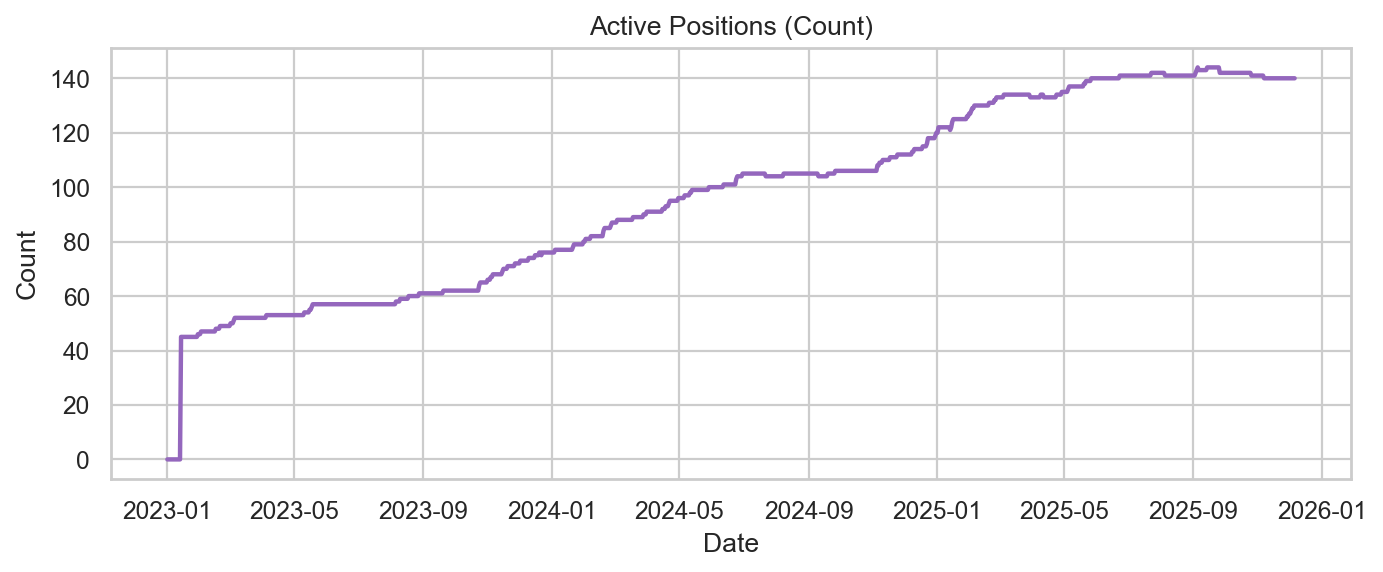
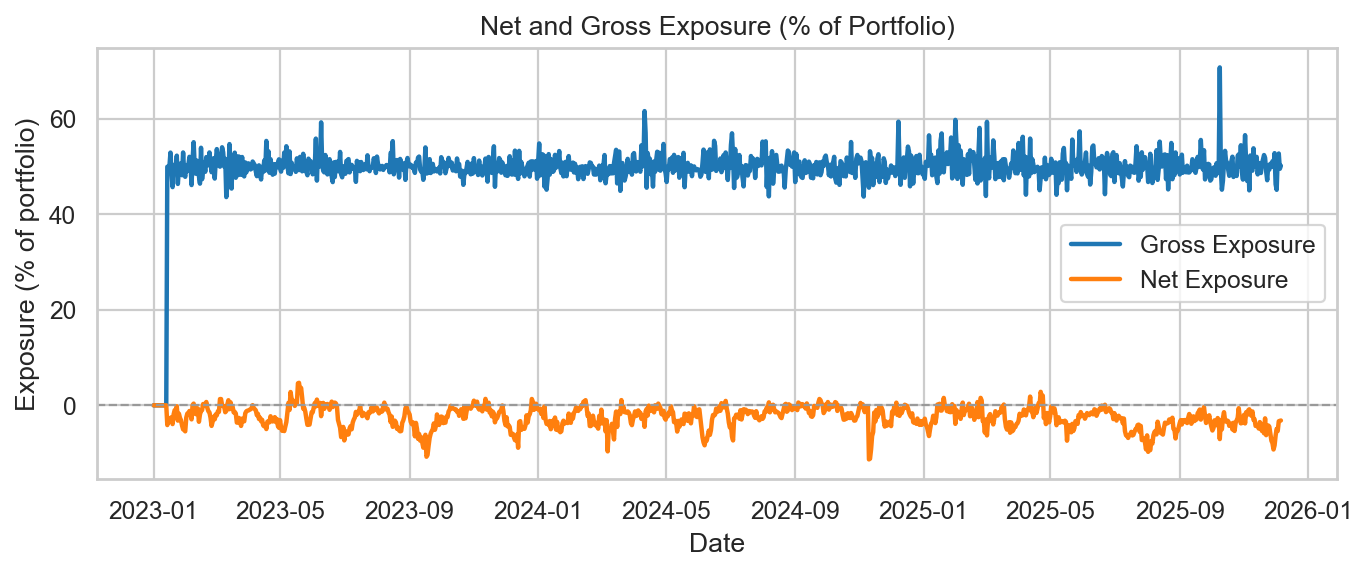
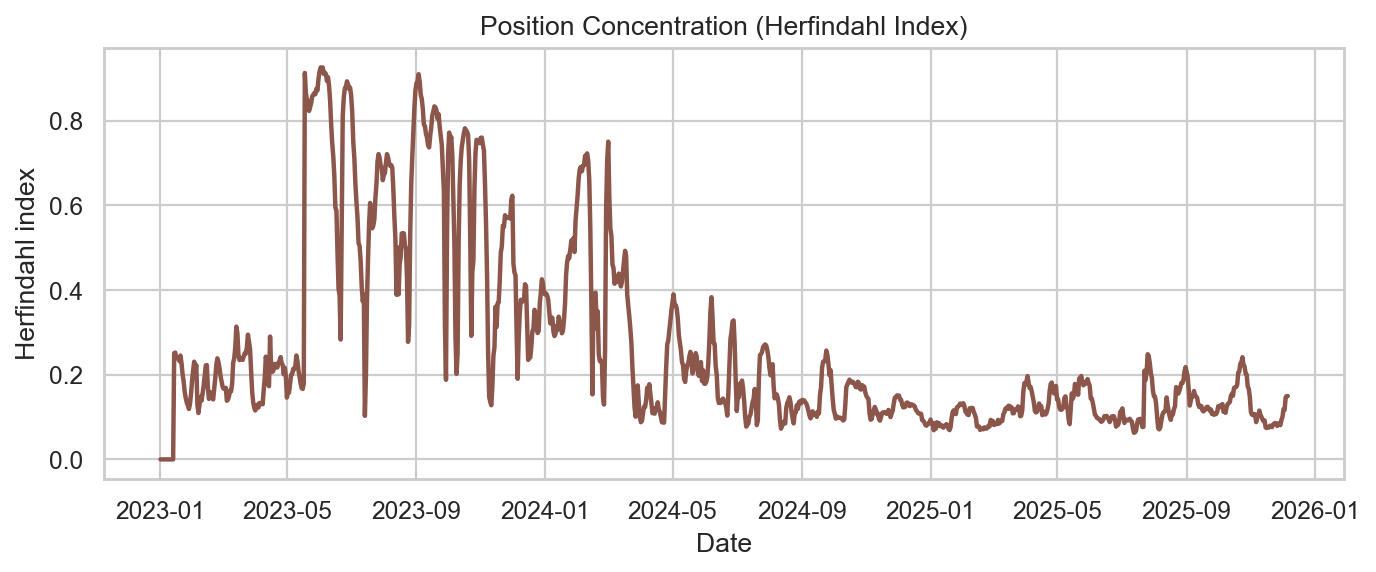
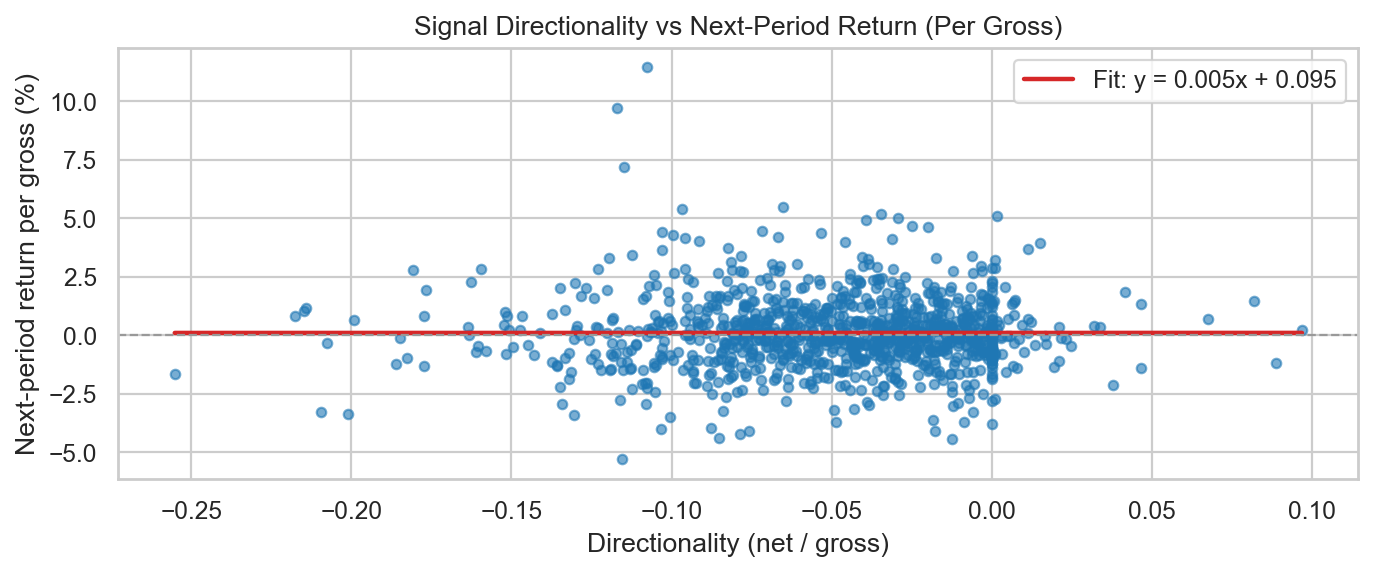
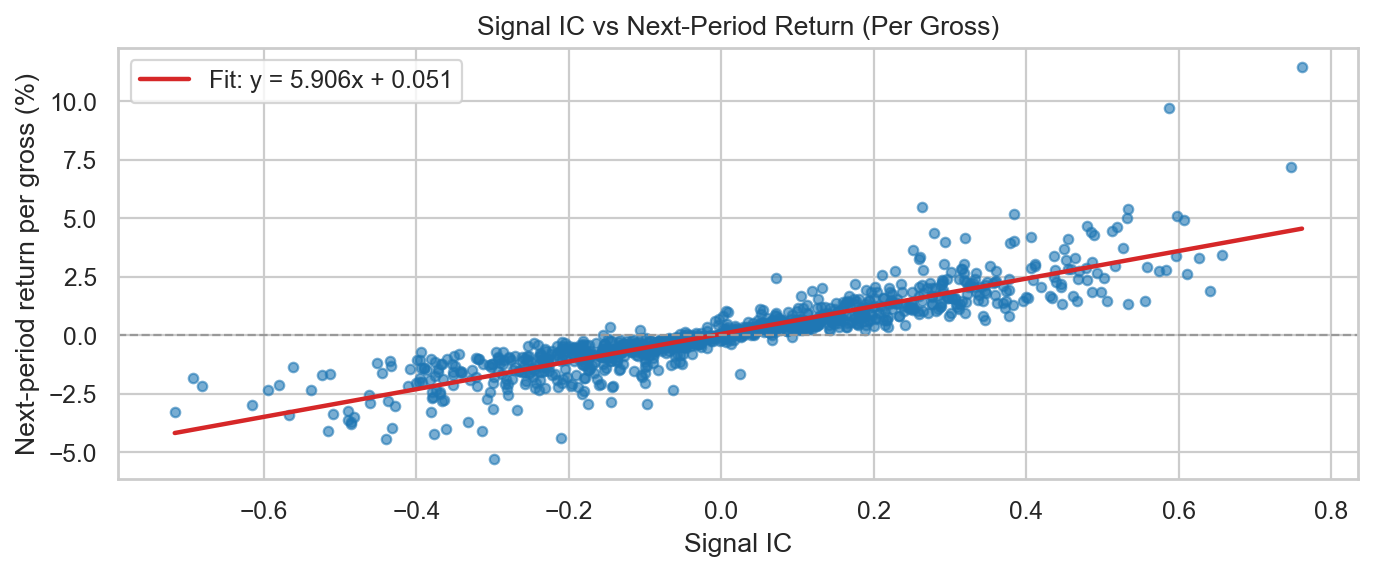
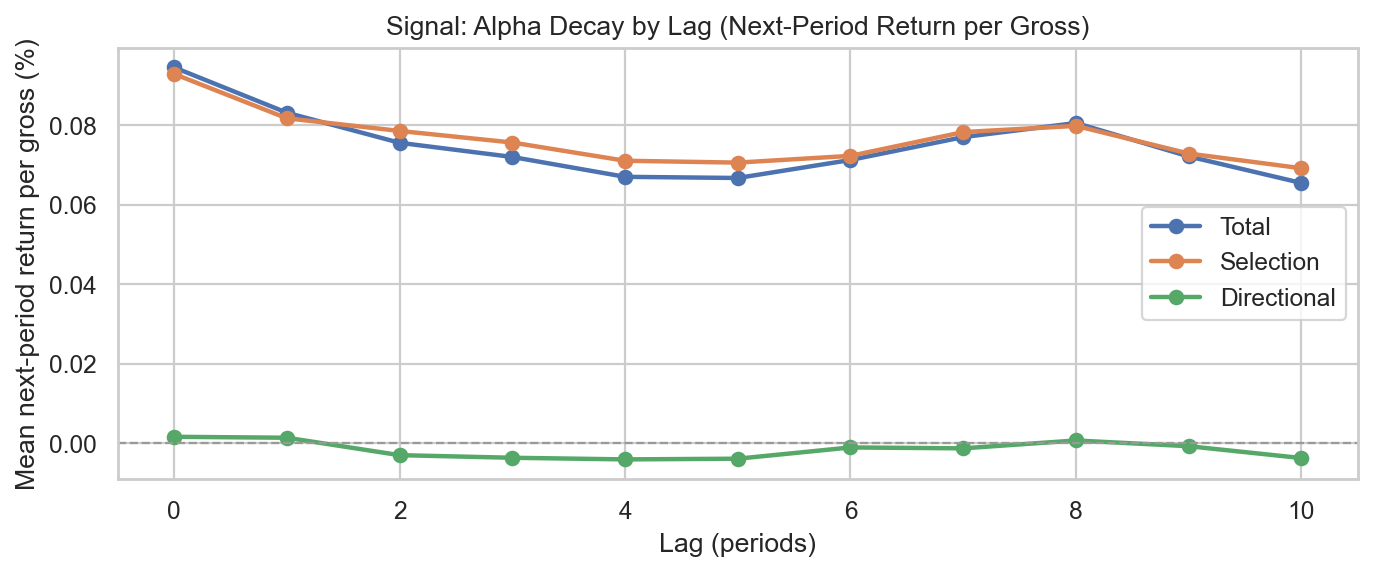
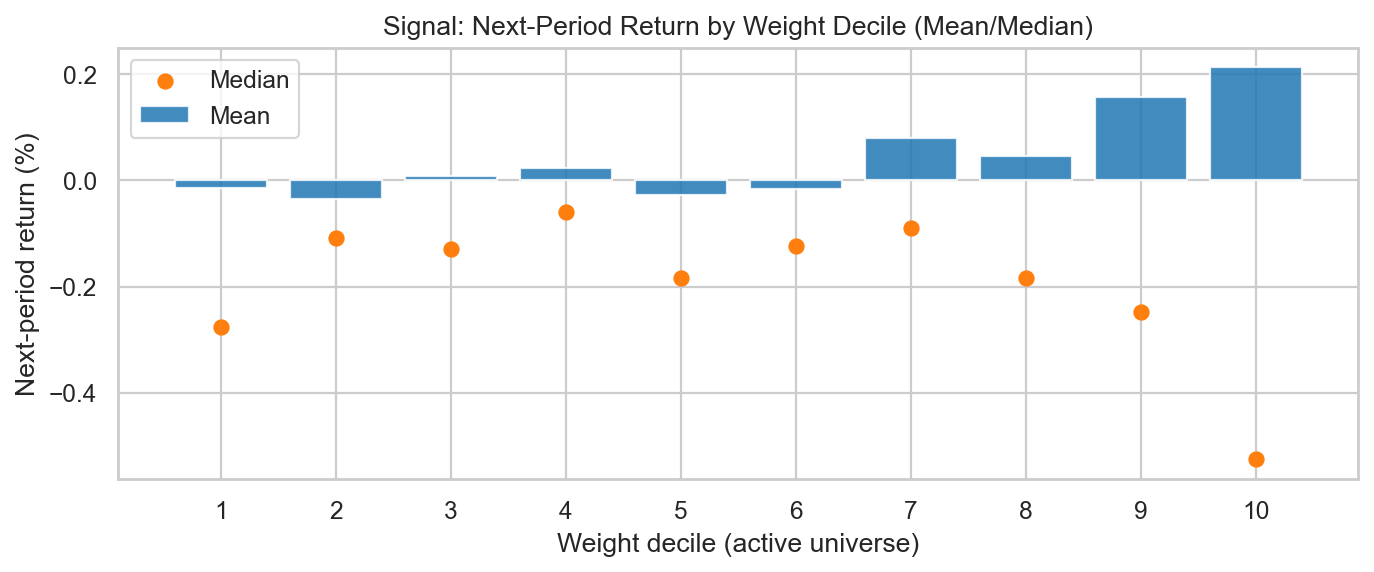
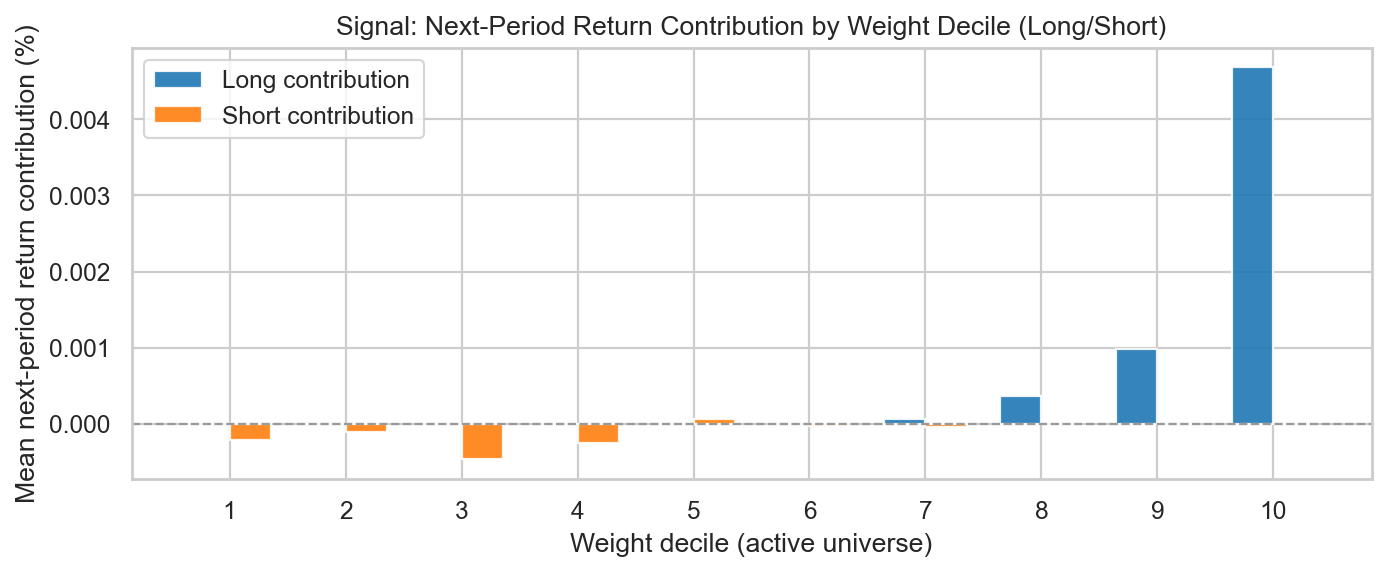
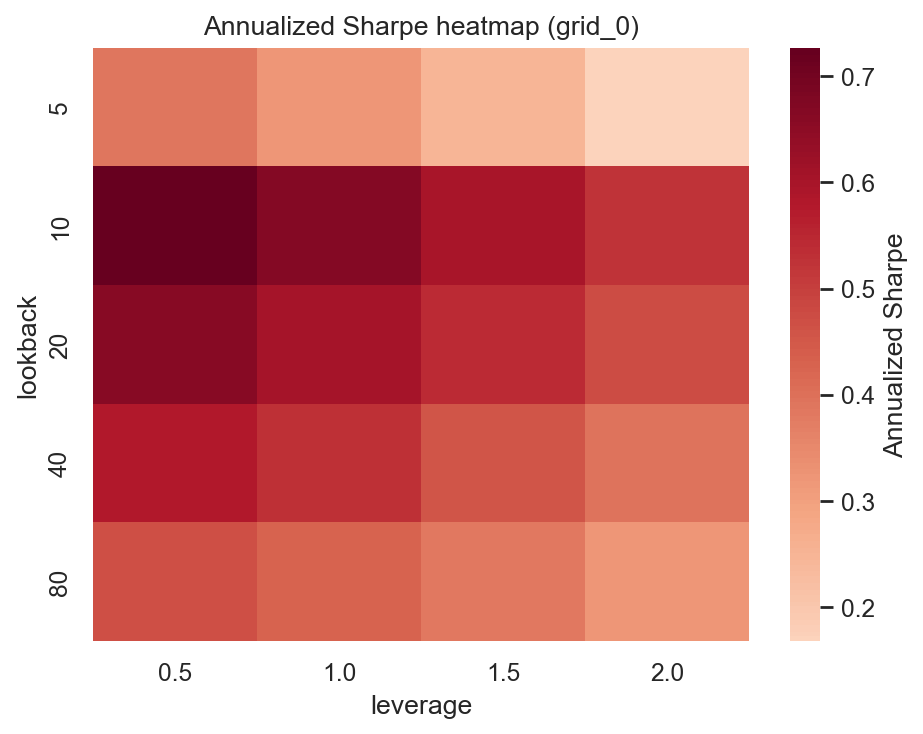
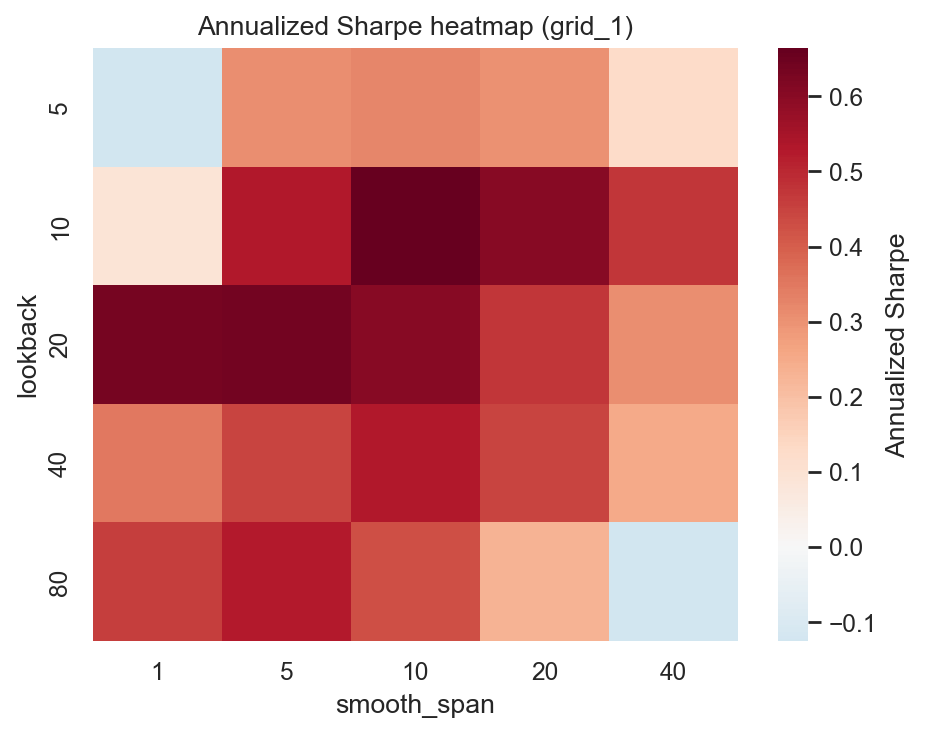

In [7]:
html_str = tearsheet(grid_results=grid_results, output_path="./search_tearsheet.html")
display(HTML(html_str))